In [6]:
import dadi

def split_no_mig_model(params, ns, pts):
    """
    Simple divergence model with no migration.
    
    params: List of parameters [nu1, nu2, T]
    ns: List of sample sizes [n1, n2]
    pts: Number of grid points
    """
    nu1, nu2, T = params
    
    # Create a grid of points
    xx = dadi.Numerics.default_grid(pts)
    
    # Initial ancestral population equilibrium
    phi = dadi.PhiManip.phi_1D(xx)
    
    # Population split at time T
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    
    # Integrate populations with size nu1 and nu2 for time T
    phi = dadi.Integration.two_pops(phi, xx, T, nu1, nu2)
    
    # Calculate the frequency spectrum
    fs = dadi.Spectrum.from_phi(phi, ns, (xx, xx))
    
    return fs

dadi.cuda_enabled(True)

Failed to import dadi.cuda


False

In [31]:
# Import your VCF data and prepare SFS
vcf_file = '/nas/longleaf/home/adaigle/work/ghist_2024_work/target_vcfs/GHIST-split-isolation.vcf'
popfile = '/nas/longleaf/home/adaigle/work/ghist_2024_work/target_vcfs/split-isolation_popfile.txt'

# Step 1: Create a data dictionary from the VCF file
dd = dadi.Misc.make_data_dict_vcf(vcf_file, popfile)

# Step 2: Define population IDs and sample sizes
pop_ids = ['east', 'west']  # The populations to extract
ns = [22, 18]  # Sample sizes (down-project if needed to make fitting faster)

# Step 3: Generate the frequency spectrum (FS) from the data dictionary
fs = dadi.Spectrum.from_data_dict(dd, pop_ids, ns)


# Define the sample sizes
ns = fs.sample_sizes
print(ns)
# Grid points for numerical integration
pts_l = [40, 50, 60]  # You can adjust this for finer or coarser grids

# Initial parameter guesses: (nu1, nu2, T)
p0 = [1, .1, 0.1]

# Generate the model SFS
func = dadi.Numerics.make_extrap_log_func(split_no_mig_model)
model = func(p0, ns, pts_l)


[22 18]


In [32]:
# Assuming you have already defined:
# popt - Optimized parameters [nu1, nu2, T]
# model - The demographic model
# fs - The observed frequency spectrum (FS)

# Step 1: Generate the model SFS using the optimized parameters
model_fs = func(popt, ns, pts_l)  # pts_l is the grid size, popt are optimized parameters

# Step 2: Calculate real theta using dadi.Inference.optimal_sfs_scaling
theta = dadi.Inference.optimal_sfs_scaling(model_fs, fs)

# Print the real theta value
print(f"Real theta (θ): {theta:.5f}")

Real theta (θ): 184529.00569


In [33]:
# Bounds for parameters (nu1, nu2, T)
upper_bound = [100, 100, 100]
lower_bound = [1e-2, 1e-2, 1e-5]
# Compare the model to data (you can use a log-likelihood function)
ll_model = dadi.Inference.ll_multinom(model, fs)

# Optimize parameters
popt = dadi.Inference.optimize_log(p0, fs, func, pts_l, lower_bound=lower_bound, upper_bound=upper_bound)
print(popt)

[1.27352068 0.19931804 0.06580613]


In [34]:
# Given parameters from your dadi analysis
popt = [1.5, 2.0, 0.1]  # Example popt [nu1, nu2, T] after optimization

# Mutation rate (per generation per base pair)
mu = 5.7e-9

# Size of genomic region sequenced (in base pairs)
L = 100_000_000

# Generation time (in years)
generation_time = 0.75

# Assume theta was calculated earlier or comes from dadi results:

# Step 1: Calculate the ancestral population size (N_a)
N_a = theta / (4 * mu * L)

# Step 2: Convert nu1 and nu2 to actual population sizes
nu1, nu2, T = popt  # Optimized values
N1 = nu1 * N_a
N2 = nu2 * N_a

# Step 3: Convert scaled time (T) to actual time in generations
T_gen = T * 2 * N_a  # Time of split in generations

# Step 4: Convert time in generations to time in years
T_years = T_gen * generation_time  # Time of split in years

# Print the results
print(f"Ancestral population size (N_a): {N_a:.2f}")
print(f"Population size of east (N1): {N1:.2f}")
print(f"Population size of west (N2): {N2:.2f}")
print(f"Time of split in generations: {T_gen:.2f}")
#print(f"Time of split in years: {T_years:.2f}")

Ancestral population size (N_a): 80933.77
Population size of east (N1): 121400.66
Population size of west (N2): 161867.55
Time of split in generations: 16186.75


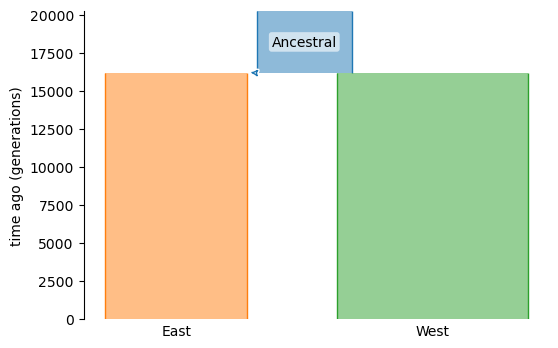

In [36]:
import demes
import demesdraw
import matplotlib.pyplot as plt

# Define the demographic model using a YAML string format
yaml_model = f"""
description: Split with no migration
time_units: generations
demes:
  - name: Ancestral
    start_time: .inf  # Use YAML's infinite time
    epochs:
      - end_time: {T_gen:.2f}
        start_size: {N_a:.2f}
  - name: East
    start_time: {T_gen:.2f}
    ancestors: [Ancestral]
    epochs:
      - end_time: 0
        start_size: {N1:.2f}
  - name: West
    start_time: {T_gen:.2f}
    ancestors: [Ancestral]
    epochs:
      - end_time: 0
        start_size: {N2:.2f}
"""



# Load the YAML model into a demes graph object
graph = demes.loads(yaml_model)

# Visualize the model
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
demesdraw.tubes(graph, ax=ax)
plt.show()

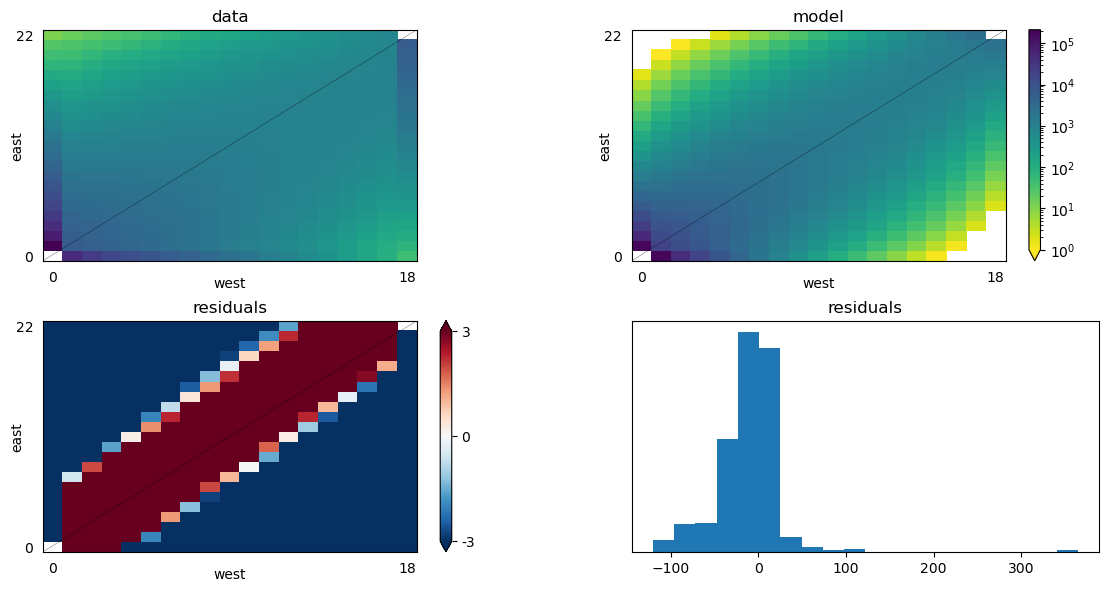

In [35]:
import dadi
import matplotlib.pyplot as plt

# Assuming `fs` is your observed frequency spectrum from the real data
# Assuming `popt` are the optimized parameters from the inferred model

# 1. Generate the model frequency spectrum using the optimized parameters
# Your demographic model function should be already defined (e.g., split_no_mig_model)
model = func(popt, fs.sample_sizes, pts_l)

# 2. Plot the comparison between the observed and model frequency spectrum
fig = plt.figure(figsize=(12, 6))

# Use dadi's plotting function to compare the observed and model FS
dadi.Plotting.plot_2d_comp_multinom(model, fs, vmin=1, resid_range=3)

plt.show()